In [10]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = 'ec4f50ed-33c6-4e8d-806c-f6ca435c18bd'
CLIENT_SECRET = '&E}d~KiDvRmIUmZ>fd+h_TF*mg#:g~[<bPI<ix<E'
config = SHConfig()


if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
    

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [42]:
betsiboka_coords_wgs84 = [45,15,44,14]
resolution = 300
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 300 m resolution: (360, 368) pixels


[[1572.1473 1558.9335 1454.7375 ... 1390.0676 1387.6942 1428.3146]
 [1527.0775 1523.6107 1438.2754 ... 1389.3438 1387.5822 1441.9097]
 [1541.4788 1448.1069 1399.2446 ... 1391.1982 1391.2546 1430.0355]
 ...
 [1530.9237 1543.7949 1495.3934 ... 1755.7568 1703.2273 1763.056 ]
 [1442.6652 1461.4926 1590.4108 ... 1749.2238 1693.904  1765.1493]
 [1521.7109 1604.456  1756.5621 ... 1710.1187 1669.342  1698.4897]]


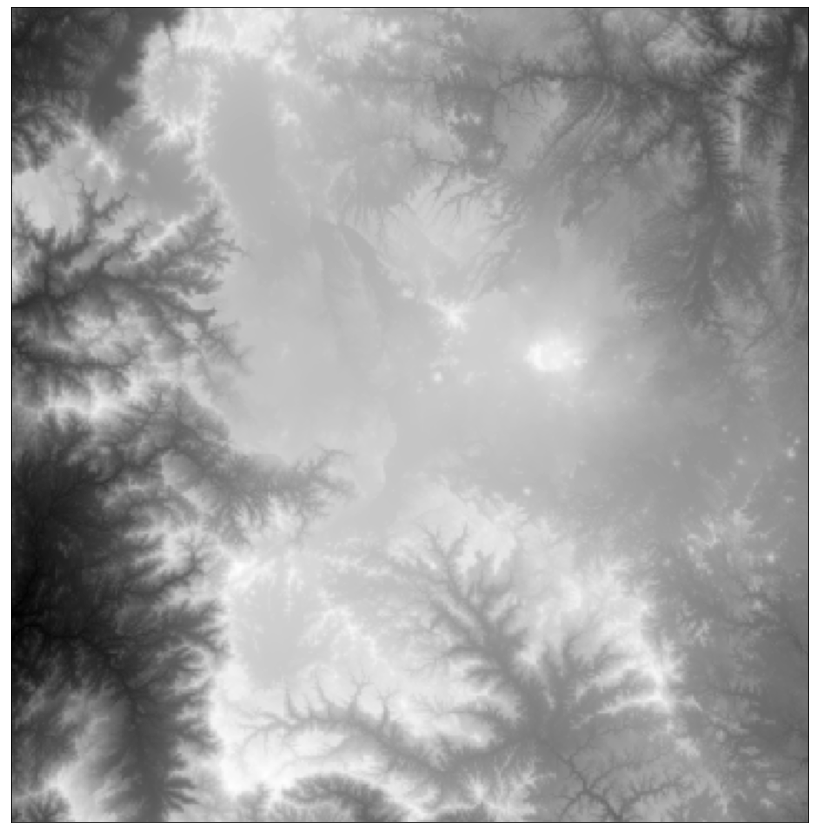

In [49]:
evalscript_dem = '''
//VERSION=3
function setup() {
  return {
    input: ["DEM"],

    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
'''

dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=('2020-06-12', '2020-06-13'),
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

dem_data = dem_request.get_data()

# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
print(dem_data[0])
#print(dem_data[1])
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=np.amin(dem_data[0]), vmax=np.amax(dem_data[0]))
data = dem_data[0]


In [63]:

data
# x y 
#data[0][0] 

new_data = list(map(lambda x: list(map(lambda y: (y,False),x)) ,data))

In [93]:

sel_x = 155
sel_y = 200

test = [[0,0,1,0,2,0],[0,0,0,0,0,0]]

#test =list(map(lambda x: list(map(lambda y: (y,False),x)) ,data))

list(map(list, zip(*test)))


[[0, 0], [0, 0], [1, 0], [0, 0], [2, 0], [0, 0]]

In [95]:
def find_closest(data, x, y, amount_x, amount_y, amount_z):
    final_array = []
    
    curr_x = x + amount_x
    curr_y = y + amount_y
    curr_z = data[curr_x][curr_y] 
    print(curr_x, curr_y, curr_z)
    while True:
        if curr_x > len(data) or curr_y > len(data[0]):
            return None
        calculated_z = data[curr_x][curr_y]
        if abs(calculated_z - curr_z) < 1:
            return (curr_x, curr_y)
        else:
            curr_x += amount_x
            curr_y += amount_y
            curr_z += amount_z     
        
find_closest(test, x=0,y=0, amount_x=110, amount_y=20, amount_z=100)

  

110 20 100
imhere


In [108]:
def build_ray_arree(data, x, y, amount_x, amount_y):
    final_array = []
    data = np.array(list(map(list, zip(*data))))
    curr_x = x 
    curr_y = y
    while True:
        if curr_x >= len(data) or curr_y >= len(data[0]) or curr_x < 0 or curr_y < 0:
            return final_array
        
        final_array.append(data[curr_x][curr_y])
        curr_x += amount_x
        curr_y += amount_y

build_ray_arree(test, x=0,y=0, amount_x=0, amount_y=1)




[0, 0]

In [131]:
z = np.array([100,70,30,20,60,80,90,100,120,40,20,145,170])


#is_left(np.array([0,100]),np.array([1,70]),np.array([2,30]))


array([[  0, 100],
       [  1,  70],
       [  2,  30],
       [  3,  20],
       [  4,  60],
       [  5,  80],
       [  6,  90],
       [  7, 100],
       [  8, 120],
       [  9,  40],
       [ 10,  20],
       [ 11, 145],
       [ 12, 170]])

In [138]:
def direction(p1, p2, p3):
      return np.cross(p3 - p1, p2 - p1)
    
def is_left(p1, p2, p3):
    return direction(p1, p2, p3) < 0


def seeable_points(arr):
    arr = np.array(list(zip(np.arange(len(arr)),arr)))
    print(arr)
    start = arr[0]
    middle = arr[1]
    
    final_arr = list()
    final_arr.append(True)
    final_arr.append(True)
    
    
    for element in arr[2:]:
        if is_left(start,middle,element):
            middle = element
            final_arr.append(True)
        else:
            final_arr.append(False)
    
    return np.array(final_arr)


[100  70  30  20  60  80  90 100 120  40  20 145 170]
[[  0 100]
 [  1  70]
 [  2  30]
 [  3  20]
 [  4  60]
 [  5  80]
 [  6  90]
 [  7 100]
 [  8 120]
 [  9  40]
 [ 10  20]
 [ 11 145]
 [ 12 170]]


array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True])

In [113]:
np.array((1,1)) - np.array((2,3))

array([-1, -2])

In [ ]:
for x in range(len(data)):
    for y in range(len(data[0]))
        
    

In [72]:
plt.imsave('fig.png', img)